In [49]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from utils import load_checkpoint
from models.captioning import CaptionNet, CaptionNetV3

import config

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import os
import json

from models.compress import HyperpriorWrapper

from datasets.captioning.dataset_decoded import DecodedImageDataset, as_matrix
from datasets.captioning import coco_tag, annotations

from torchvision import transforms as T

%matplotlib inline

In [94]:
config.DEVICE

'cuda'

In [95]:
network_config

{'n_tokens': 10403,
 'emb_size': 512,
 'pad_ix': 3,
 'lstm_units': 512,
 'feature_size': 2048,
 'cnn_in_channels': 192}

In [98]:
# network = CaptionNet(n_tokens, pad_ix=pad_ix, cnn_feature_size=512 * 49,
#                      cnn_in_channels=192, cnn_out_channels=512, pool=2).to(config.DEVICE)

tag = "capts_co_v3_e100_1e3"
# with open(f"checkpoints/{tag}/network_config.json") as f:
#     network_config = json.load(f)

network_config = {'n_tokens': 10403,
 'emb_size': 256,
 'pad_ix': 3,
 'lstm_units': 256,
 'feature_size': 2048,
 'cnn_in_channels': 192}

network = CaptionNetV3(**network_config).to(config.DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=config.LEARNING_RATE)

In [99]:
checkpoint = sorted(filter(lambda x: x.endswith(".tar"), os.listdir("checkpoints/" + tag)))[-1]
print(checkpoint)
load_checkpoint(f"checkpoints/{tag}/" + checkpoint,
                network, optimizer,
                config.LEARNING_RATE)

007.pth.tar
=> Loading checkpoint


In [100]:
dataset = DecodedImageDataset(
    coco_tag("co1d"),
    os.path.join(annotations, "captions_train2017_tok.json"),
)

In [101]:
vocab = dataset.vocab

In [102]:
# from models.beheaded_inception3 import beheaded_inception_v3
# inception = beheaded_inception_v3().train(False)

In [103]:
compressor = HyperpriorWrapper(1, pretrained=True).eval().to(config.DEVICE)

In [176]:
def generate_caption(image, caption_prefix=("#START#",), t=1, sample=True, max_len=100):

    # assert (
    #     isinstance(image, np.ndarray)
    #     and np.max(image) <= 1
    #     and np.min(image) >= 0
    #     and image.shape[-1] == 3
    # )

    with torch.no_grad():
        # image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(
        #     config.DEVICE
        # )

        # vectors_8x8, vectors_neck, logits = inception(image[None])
        # compressed = compressor.compress(image[None])
        # vectors_neck = compressor.entropy_decode(compressed["strings"], compressed["shape"])
        vectors_neck = image
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix], dataset.pad_ix, dataset.unk_ix, dataset.word_to_index)
            print(prefix_ix)
            # prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(
                vectors_neck.to(config.DEVICE), prefix_ix.to(config.DEVICE)
            )[0, -1]
            next_word_probs = (
                F.softmax(next_word_logits, dim=-1).data.detach().cpu().numpy()
            )
            next_word_probs = next_word_probs.clip(0)
            assert len(next_word_probs.shape) == 1, "probs must be one-dimensional"
            next_word_probs = next_word_probs**t / np.sum(
                next_word_probs**t
            )  # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

AttributeError: 'numpy.ndarray' object has no attribute 'to'

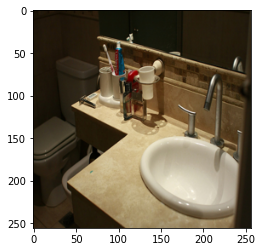

In [105]:
# sample image
# path = 'datasets/image_captioning/flickr30k_images/flickr30k_images/'
path = "datasets/captioning/coco2017/"
image = random.choice(os.listdir(path))
img = plt.imread(os.path.join(path, image))
img = Image.fromarray(img).resize((256, 256))
img = np.array(img).astype("float32") / 255.0
plt.imshow(img)
for i in range(10):
    print(" ".join(generate_caption(img, t=5.0)[1:-1]))

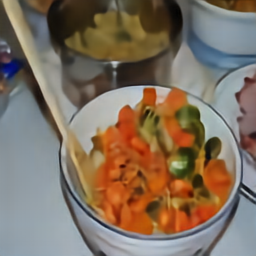

In [204]:
image, captions = dataset[random.randint(0, len(dataset))]
image = image.to(config.DEVICE)
T.ToPILImage()(compressor.decode(image).squeeze())

In [169]:
[" ".join(capt) for capt in captions]

['#START# a bedroom with a bookcase and a double bed #END#',
 '#START# it is a bedroom with a bed and bookcase . #END#',
 '#START# a bedroom with a book case and several books . #END#',
 '#START# a book case sits between the window and the bed . #END#',
 '#START# a neat bedroom containing a small bookcase #END#']

In [177]:
# for i in range(10):
print(" ".join(generate_caption(image, t=5.0)[1:-1]))

tensor([[1]])
tensor([[ 1, 14]])
tensor([[  1,  14, 242]])
tensor([[  1,  14, 242,  18]])
tensor([[  1,  14, 242,  18,  14]])
tensor([[  1,  14, 242,  18,  14,  92]])
tensor([[  1,  14, 242,  18,  14,  92,  16]])
tensor([[  1,  14, 242,  18,  14,  92,  16,  33]])
tensor([[  1,  14, 242,  18,  14,  92,  16,  33,  14]])
tensor([[  1,  14, 242,  18,  14,  92,  16,  33,  14, 797]])
tensor([[  1,  14, 242,  18,  14,  92,  16,  33,  14, 797, 798]])
tensor([[  1,  14, 242,  18,  14,  92,  16,  33,  14, 797, 798,  13]])
a man in a suit is holding a tennis racket .
